In [1]:
import matplotlib.pyplot as plt
import time
import os
import pickle

import torch
import numpy as np
from scipy.stats import linregress
from tqdm.notebook import tqdm  # Use tqdm if you're not in a notebook environment

from sbi import analysis
from sbi import utils as utils
from sbi.utils.user_input_checks import process_prior

from simulations_model2 import simulator_sbi_entropy

from parsing_functions import save_pickle_data, load_inference_data, extract_specs, specs_hash

In [2]:
# Compute entropies function that derives a single error from a broader number of different entropies
from joblib import Parallel, delayed

def simulate_entropy(theta, simulator_to_sbi_entropy):
    x_obs, S, S_analytic = simulator_to_sbi_entropy(theta)
    return S

def compute_entropies_log(n_points, samplings, L_thr, theta_true, simulator_to_sbi_entropy, posterior, n_jobs=10, batch_size=5):

    S = []
    S_mean= []
    S_error = []
    S_analytic = []


    for i in tqdm(range(n_points), desc="Computing entropies"):
        # Simulate entropy for observed points
                  
        x_obs1, S1, S1analytic = simulator_to_sbi_entropy(theta_true[i])
        S.append(S1)
        S_analytic.append(S1analytic)
        
        # Generating likelihoods and new entropy samples from that
        samples_i = posterior.sample((samplings,) , x=x_obs1, show_progress_bars=False)
        log_prob_samples_i = posterior.log_prob(samples_i, x=x_obs1)
        
        max_log_prob = torch.max(log_prob_samples_i)
        normalized_log_prob_samples_i = log_prob_samples_i / max_log_prob
        threshold = L_thr
        indices = torch.where(normalized_log_prob_samples_i > threshold)[0]
        samples_i_trunc = samples_i[indices]
        log_prob_samples_i_trunc = log_prob_samples_i[indices]
        
        S_single_values = Parallel(n_jobs=n_jobs, batch_size=batch_size)(
            delayed(simulate_entropy)(samples_i_trunc[j], simulator_to_sbi_entropy) for j in range(len(samples_i_trunc))
        )
        
        S_single_values = torch.tensor(S_single_values)  # Convert to tensor
        
        S_logprob_products = S_single_values * log_prob_samples_i_trunc
        S2_logprob_products = (S_single_values ** 2) * log_prob_samples_i_trunc
        
        sum_log_prob_trunc = torch.sum(log_prob_samples_i_trunc)
  
        S_mean_i = torch.sum(S_logprob_products) / sum_log_prob_trunc
        S2_mean_i = torch.sum(S2_logprob_products) / sum_log_prob_trunc
        
        S_variance_i = S2_mean_i - (S_mean_i ** 2)
        
        S_error_i = torch.sqrt(S_variance_i)

        S_mean.append(S_mean_i)
        S_error.append(S_error_i)

    return S, S_mean, S_analytic, S_error

In [3]:
posterior_dir = 'saved_posteriors/'
posterior_name = 'posterior_366eb24ca0e06eb1e96ac05dfd2df8da.pickle'
posterior_path = os.path.join(posterior_dir, posterior_name)

# Extract the specifications
specs_dict = extract_specs(posterior_path)
print(specs_dict)
# Unpack the specifications from the dictionary
num_simulations = specs_dict['num_simulations']
Npts = specs_dict['Npts']
dt = specs_dict['dt']
oversampling = specs_dict['oversampling']
prerun = specs_dict['prerun']

high_tensor = specs_dict['high_tensor']
low_tensor = specs_dict['low_tensor']
features = specs_dict['features']

with open(posterior_path, "rb") as handle:
    data_posterior = pickle.load(handle)

posterior = data_posterior['posterior']

{'num_simulations': 1000, 'Npts': 50000.0, 'dt': 0.01, 'oversampling': 5, 'prerun': 1000.0, 'low_tensor': tensor([0.0000, 0.0100, 0.0000]), 'high_tensor': tensor([2, 2, 1]), 'features': ['Cxx', 'S_red_x', 'Cxy', 'Cyy', 'S_red_y']}


In [4]:
def simulator_to_sbi_entropy(pars):
    return simulator_sbi_entropy(torch.Tensor.numpy(pars), dt, int(oversampling), int(prerun),int(Npts), features = features)

prior_sbi = utils.BoxUniform(low=low_tensor, high=high_tensor)

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_sbi)

In [5]:
theta_true = prior.sample((1,))
print(theta_true)
# generate our observation

x_obs, S, S_analytic = simulator_to_sbi_entropy(theta_true[0])
samples = posterior.sample((250000,), x=x_obs)

tensor([[1.9647, 1.8479, 0.1113]])


Drawing 250000 posterior samples:   0%|          | 0/250000 [00:00<?, ?it/s]

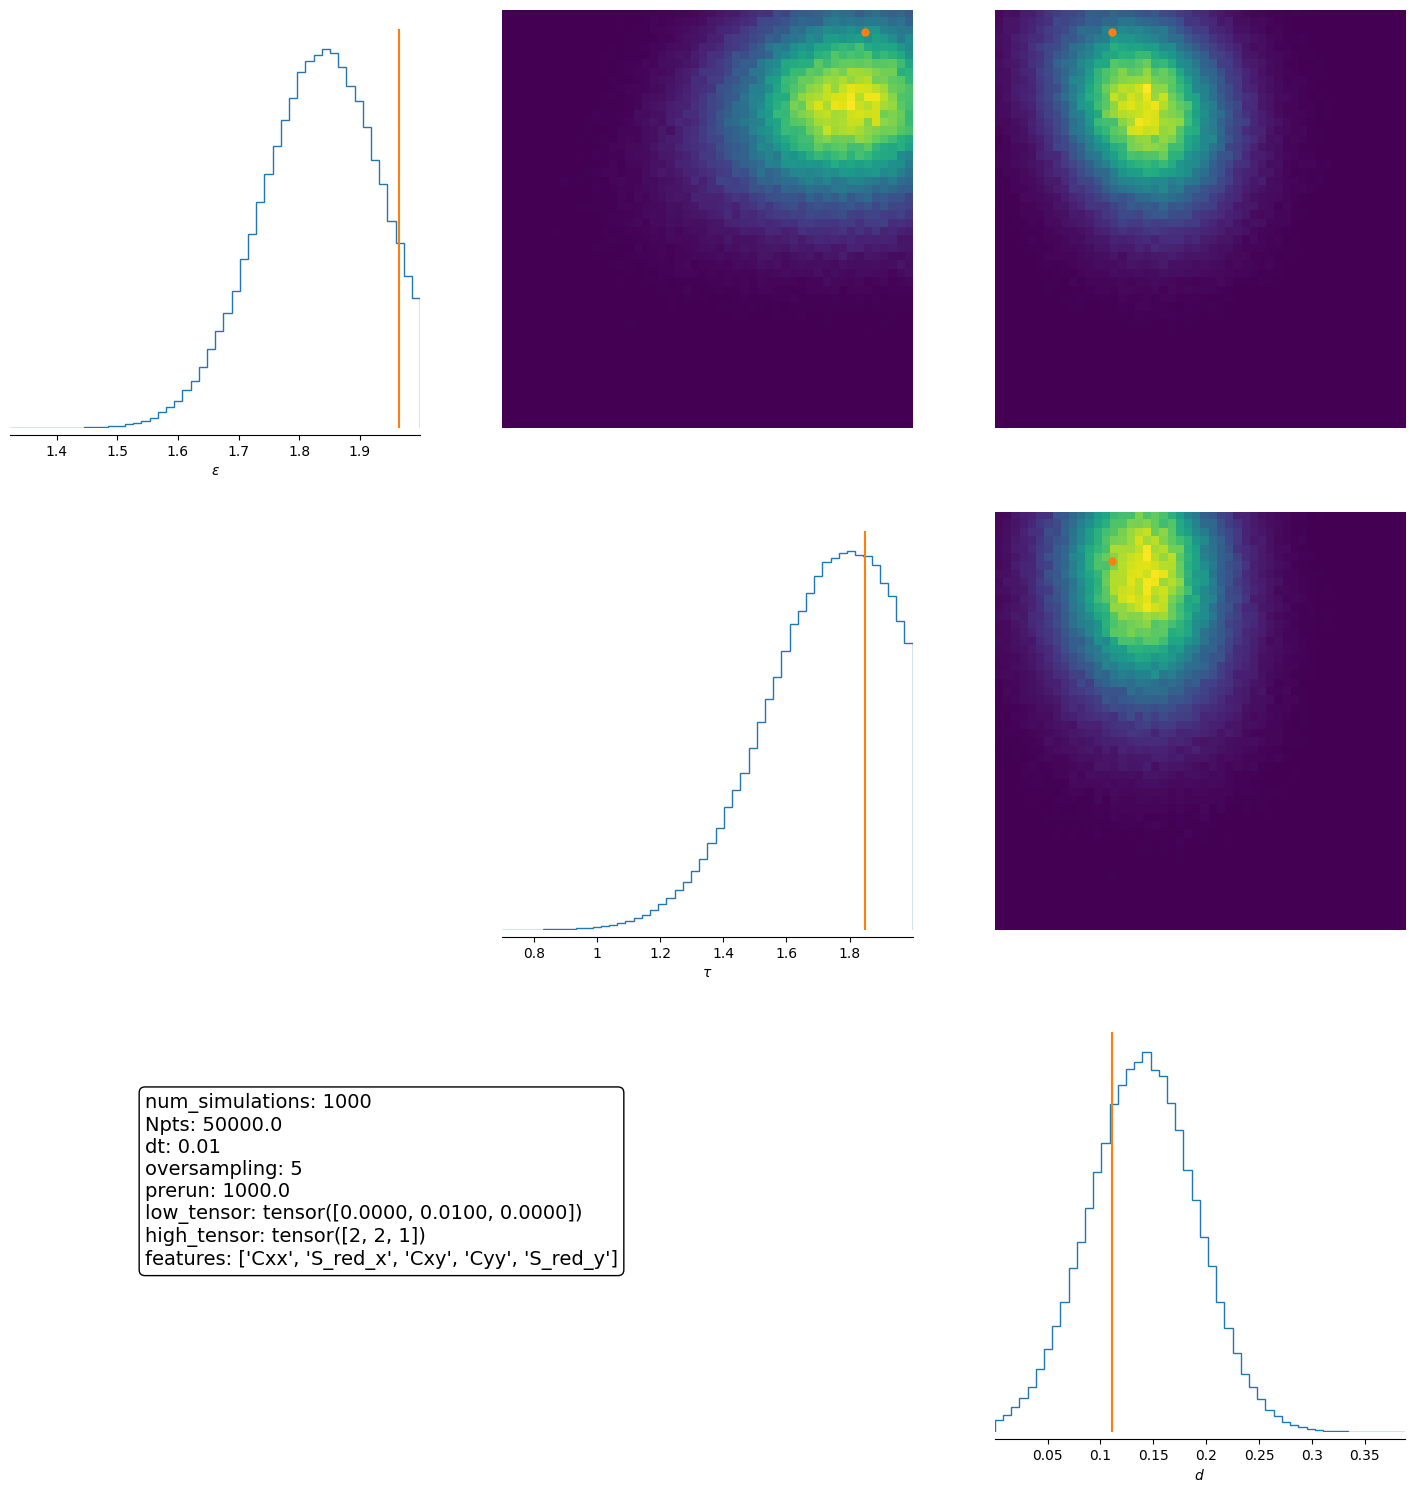

In [6]:
fig,ax = analysis.pairplot(samples, points=theta_true, figsize=(18, 18),labels=[r"$\epsilon$", r"$\tau$", r"$d$"])


# Generate the specs hash
specs_hash_value = specs_hash(specs_dict)

fig_save_dir = 'saved_figures/'
fig_name = f'analysisSNPE_{specs_hash_value}.png'

# Convert metadata dictionary to a string
metadata_text = "\n".join([f"{key}: {value}" for key, value in specs_dict.items()])

# Add text box with metadata
text_box = fig.text(
    0.2, 0.2, metadata_text,
    fontsize=14,
    verticalalignment='bottom',
    horizontalalignment='left',
    bbox=dict(facecolor='white', alpha=1, boxstyle='round,pad=0.3')
)

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir): os.makedirs(fig_save_dir)
fig_path = os.path.join(fig_save_dir, fig_name)

fig.savefig(fig_path, dpi = 300)

In [7]:
%%time

n_points = 10
samplings = 100
L_thr = 0.65
theta_trues = prior.sample((n_points,))

S, S_mean, S_analytic, S_error = compute_entropies_log(n_points, samplings, L_thr, 
                                                       theta_trues, simulator_to_sbi_entropy, 
                                                       posterior, n_jobs = 8, batch_size =10) 
#you can adjust n_jobs with number of threads you prefer, and batch_size too

Computing entropies:   0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 1min 9s, sys: 17.9 s, total: 1min 27s
Wall time: 1min 9s


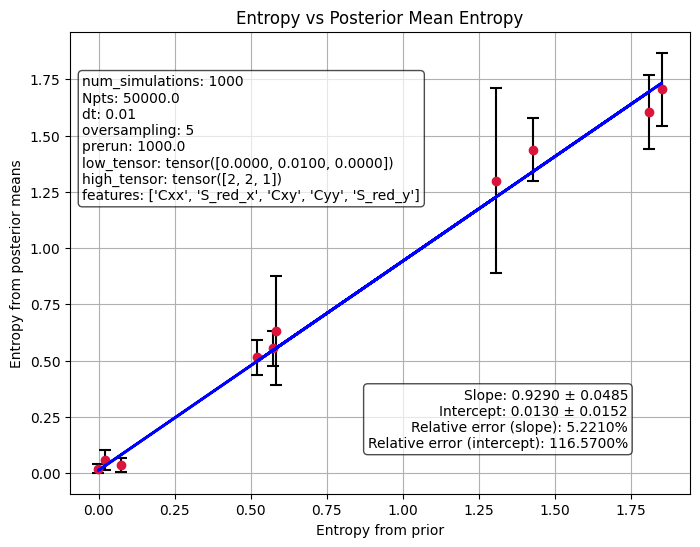

In [8]:
from scipy.optimize import curve_fit

def linear_model(x, a, b):
    return a * x + b


# fitting function for y errors
def fit_with_errors(x, y, y_err):
    def combined_error(params, x, y, y_err):
        a, b = params
        model = a * x + b
        return (y - model) / np.sqrt(y_err**2)
    
    # initial guesses
    initial_guess = [1, 0]
    
    # fit
    popt, pcov = curve_fit(linear_model, x, y, sigma=y_err, absolute_sigma=True, p0=initial_guess)
    
    # error from covariance matrix
    perr = np.sqrt(np.diag(pcov))
    return popt, perr

# execute the fit
popt, perr = fit_with_errors(S, S_mean, S_error)
slope, intercept = popt
slope_err, intercept_err = perr

# regression line for plot
regression_line = intercept + slope * np.array(S)

relative_error_slope = slope_err / slope if slope != 0 else np.nan
relative_error_intercept = intercept_err / intercept if intercept != 0 else np.nan

# Plot scatter plot
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 6))
s = 60
ax2.errorbar(S, S_mean, yerr=S_error, fmt='o', color='crimson', ecolor='black', elinewidth=1.5, capsize=4, capthick=1.5, zorder=2)

# Plot regression line
ax2.plot(S, regression_line, color='blue', linewidth=2, zorder=3)

# Convert metadata dictionary to a string
metadata_text = "\n".join([f"{key}: {value}" for key, value in specs_dict.items()])

# Add text box with metadata
text_box = fig2.text(
    0.02, .63, metadata_text,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    transform=ax2.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add linear regression parameters and relative errors to the plot
regression_text = (
    f"Slope: {slope:.4f} ± {slope_err:.4f}\n"
    f"Intercept: {intercept:.4f} ± {intercept_err:.4f}\n"
    f"Relative error (slope): {relative_error_slope:.4%}\n"
    f"Relative error (intercept): {relative_error_intercept:.4%}"
)
ax2.text(
    0.9, 0.1, regression_text,
    fontsize=10,
    verticalalignment='baseline',
    horizontalalignment='right',
    transform=ax2.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add labels and grid
ax2.set_xlabel("Entropy from prior")
ax2.set_ylabel("Entropy from posterior means")
ax2.set_title("Entropy vs Posterior Mean Entropy")
ax2.grid(True)

# Save the figure
fig_save_dir2 = 'saved_plots/'
fig_name2 = f'entropyerrors_{specs_hash_value}.png'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir2): os.makedirs(fig_save_dir2)
fig_path2 = os.path.join(fig_save_dir2, fig_name2)

fig2.savefig(fig_path2, dpi=600)

plt.show()


### logscale version of the same fit, beware of zeros in your dataset to run this

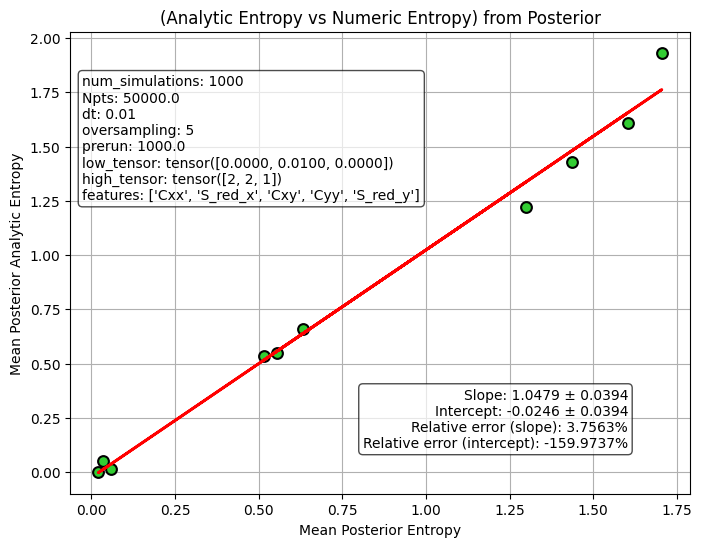

In [10]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(S_mean, S_analytic)
regression_line = intercept + slope * np.array(S_mean)

# Calculate relative errors
relative_error_slope = std_err / slope if slope != 0 else np.nan
relative_error_intercept = std_err / intercept if intercept != 0 else np.nan

# Plot scatter plot
fig3, ax3 = plt.subplots(1, 1, figsize=(8, 6))
s = 60
ax3.scatter(np.array(S_mean), np.array(S_analytic), s=s, edgecolor='black', lw=1.5, facecolor='limegreen', zorder=2)

# Plot regression line
ax3.plot(S_mean, regression_line, color='red', linewidth=2, zorder=3)

# Add text box with metadata
text_box = fig3.text(
    0.02, .63, metadata_text,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    transform=ax3.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add linear regression parameters and relative errors to the plot
regression_text = (
    f"Slope: {slope:.4f} ± {std_err:.4f}\n"
    f"Intercept: {intercept:.4f} ± {std_err:.4f}\n"
    f"Relative error (slope): {relative_error_slope:.4%}\n"
    f"Relative error (intercept): {relative_error_intercept:.4%}"
)
ax3.text(
    0.9, 0.1, regression_text,
    fontsize=10,
    verticalalignment='baseline',
    horizontalalignment='right',
    transform=ax3.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add labels and grid
ax3.set_xlabel("Mean Posterior Entropy")
ax3.set_ylabel("Mean Posterior Analytic Entropy")
ax3.set_title("(Analytic Entropy vs Numeric Entropy) from Posterior")
ax3.grid(True)

# Save the figure
fig_save_dir3 = 'saved_plots/'
fig_name3 = f'entropy_analytic_pos_{specs_hash_value}.png'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir3): os.makedirs(fig_save_dir3)
fig_path3 = os.path.join(fig_save_dir3, fig_name3)

fig3.savefig(fig_path3, dpi=600)

plt.show()

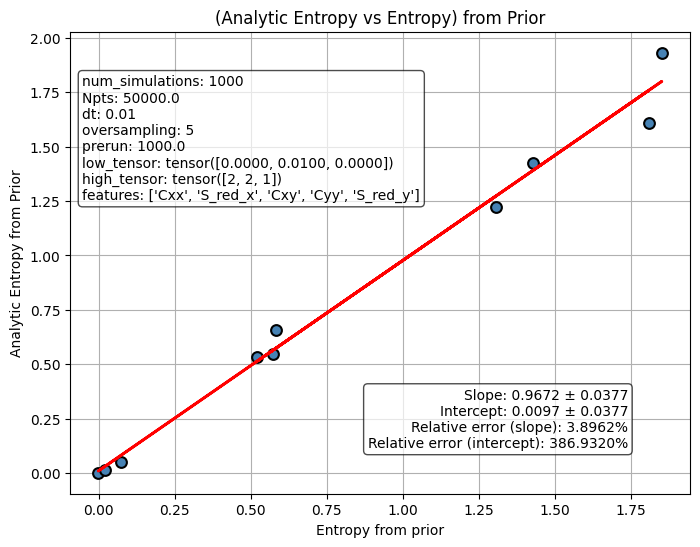

In [11]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(S, S_analytic)
regression_line = intercept + slope * np.array(S)

# Calculate relative errors
relative_error_slope = std_err / slope if slope != 0 else np.nan
relative_error_intercept = std_err / intercept if intercept != 0 else np.nan

# Plot scatter plot
fig4, ax4 = plt.subplots(1, 1, figsize=(8, 6))
s = 60
ax4.scatter(np.array(S), np.array(S_analytic), s=s, edgecolor='black', lw=1.5, facecolor='steelblue', zorder=2)

# Plot regression line
ax4.plot(S, regression_line, color='red', linewidth=2, zorder=3)

# Add text box with metadata
text_box = fig4.text(
    0.02, .63, metadata_text,
    fontsize=10,
    verticalalignment='bottom',
    horizontalalignment='left',
    transform=ax4.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add linear regression parameters and relative errors to the plot
regression_text = (
    f"Slope: {slope:.4f} ± {std_err:.4f}\n"
    f"Intercept: {intercept:.4f} ± {std_err:.4f}\n"
    f"Relative error (slope): {relative_error_slope:.4%}\n"
    f"Relative error (intercept): {relative_error_intercept:.4%}"
)
ax4.text(
    0.9, 0.1, regression_text,
    fontsize=10,
    verticalalignment='baseline',
    horizontalalignment='right',
    transform=ax4.transAxes,
    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3')
)

# Add labels and grid
ax4.set_xlabel("Entropy from prior")
ax4.set_ylabel("Analytic Entropy from Prior")
ax4.set_title("(Analytic Entropy vs Entropy) from Prior")
ax4.grid(True)

# Save the figure
fig_save_dir4 = 'saved_plots/'
fig_name4 = f'entropy_analytic_pri_{specs_hash_value}.png'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir4): os.makedirs(fig_save_dir4)
fig_path4 = os.path.join(fig_save_dir4, fig_name4)

fig4.savefig(fig_path4, dpi=600)

### interactive plot to compare paramters entries~

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from scipy.stats import linregress
import os

d=theta_trues[:,2]
t=theta_trues[:,1]
e=theta_trues[:,0]

# Esegui la regressione lineare
slope, intercept, r_value, p_value, std_err = linregress(S, S_analytic)
regression_line = intercept + slope * np.array(S)

# Calcola gli errori relativi
relative_error_slope = std_err / slope if slope != 0 else np.nan
relative_error_intercept = std_err / intercept if intercept != 0 else np.nan

# Crea il grafico scatter interattivo con Plotly
scatter = go.Scatter(
    x=S,
    y=S_analytic,
    mode='markers',
    marker=dict(size=10, color='steelblue', line=dict(width=1, color='black')),
    name='Data',
    text=[f"d: {d:.2f}<br>tau: {t:.2f}<br>epsilon: {e:.2f}" for d, t, e in zip(d, t, e)],  # Informazioni per hover
    hoverinfo='text'
)

# Crea la linea di regressione
line = go.Scatter(
    x=S,
    y=regression_line,
    mode='lines',
    line=dict(color='red', width=2),
    name='Linear regression'
)

# Testo di regressione
regression_text = (
    f"Slope: {slope:.4f} ± {std_err:.4f}<br>"
    f"Intercept: {intercept:.4f} ± {std_err:.4f}<br>"
    f"Relative error (slope): {relative_error_slope:.4%}<br>"
    f"Relative error (intercept): {relative_error_intercept:.4%}<br>"
)

# Aggiungi annotazione per i parametri di regressione
annotations = [dict(
    x=0.9,
    y=0.1,
    xref='paper',
    yref='paper',
    text=regression_text,
    showarrow=False,
    bordercolor='black',
    borderwidth=1,
    bgcolor='white',
    opacity=0.8
)]

# Crea la figura
fig = go.Figure(data=[scatter, line])

# Aggiungi titolo e etichette
fig.update_layout(
    title='Analytic Entropy vs Entropy from Prior',
    xaxis_title='Entropy from prior',
    yaxis_title='Analytic Entropy from Prior',
    annotations=annotations,
    template='plotly_white'
)

# Save the figure
fig_save_dir4 = 'saved_plotshtml/'
fig_name4 = f'entropy_analytic_pri_{specs_hash_value}.html'

# Create directory to save dataset if it doesn't exist
if not os.path.isdir(fig_save_dir4): os.makedirs(fig_save_dir4)
fig_path4 = os.path.join(fig_save_dir4, fig_name4)

fig.write_html(fig_path4)